In [1]:
!pip install -U finance-datareader

In [2]:
import FinanceDataReader as fdr

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

In [3]:
df_krx = fdr.StockListing('KRX')

In [4]:
df_krx[df_krx['Name'].str.contains('삼일')]

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
3868,032280,KOSDAQ,삼일,도로 화물 운송업,운송 및 하역수입,1997-03-15,12월,"강승엽,안인수(각자대표)",http://www.samil31.co.kr,경상북도
3869,002290,KOSDAQ,삼일기업공사,건물 건설업,도급공사,1992-11-30,12월,박종웅,http://www.samilenter.com,서울특별시
3870,004440,KOSPI,삼일씨엔에스,"시멘트, 석회, 플라스터 및 그 제품 제조업","PHC파일, 골재, 강교제작",2016-03-30,12월,강흥구,http://www.esamilcns.com,서울특별시
3871,000520,KOSPI,삼일제약,의약품 제조업,"양약(부루펜,액티피드,포리부틴) 제조,도매",1985-05-29,12월,"허승범, 김상진 (각자 대표이사)",http://www.samil-pharm.com,서울특별시


In [5]:
samil = fdr.DataReader(symbol='032280', start='2000-01-01')
samil = samil.reset_index()
samil

,Date,Open,High,Low,Close,Volume,Change
0,2000-01-04,2500,2800,2500,2800,20,0.120000
1,2000-01-05,2500,3130,2500,2500,2660,-0.107143
2,2000-01-06,2220,2780,2220,2560,205,0.024000
3,2000-01-07,2600,2600,2600,2600,1000,0.015625
4,2000-01-10,2600,2600,2600,2600,500,0.000000
...,...,...,...,...,...,...,...
5622,2022-10-13,1805,1810,1710,1720,98341,-0.054945
5623,2022-10-14,1720,1860,1720,1855,146414,0.078488
5624,2022-10-17,1855,1925,1855,1895,54879,0.021563
5625,2022-10-18,1915,1960,1915,1955,57877,0.031662


In [6]:
# 월별 날짜로 만들기

def to_month(data):
    data['month'] = data['Date']
    
    for i in range(len(data)):
        year = str(data.Date[i].year)
        month = str(data.Date[i].month)
        date = year + '-' + month
        data['month'][i] = datetime.strptime(str(date), '%Y-%m').date()
        
    data = data.drop(columns=['Date','Open','High','Low','Volume'])
    
    # df column 위치 조절
    data = data[['month','Close','Change']]
    data = data.groupby('month').mean()
    
    data = data.reset_index()
    
    # month column으로 만들기
    for j in range(len(data)):
        data.month = data.month.astype(str)
        data.month[j] = data.month[j][:7]

    return data

In [7]:
samil = to_month(samil)

<AxesSubplot:>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


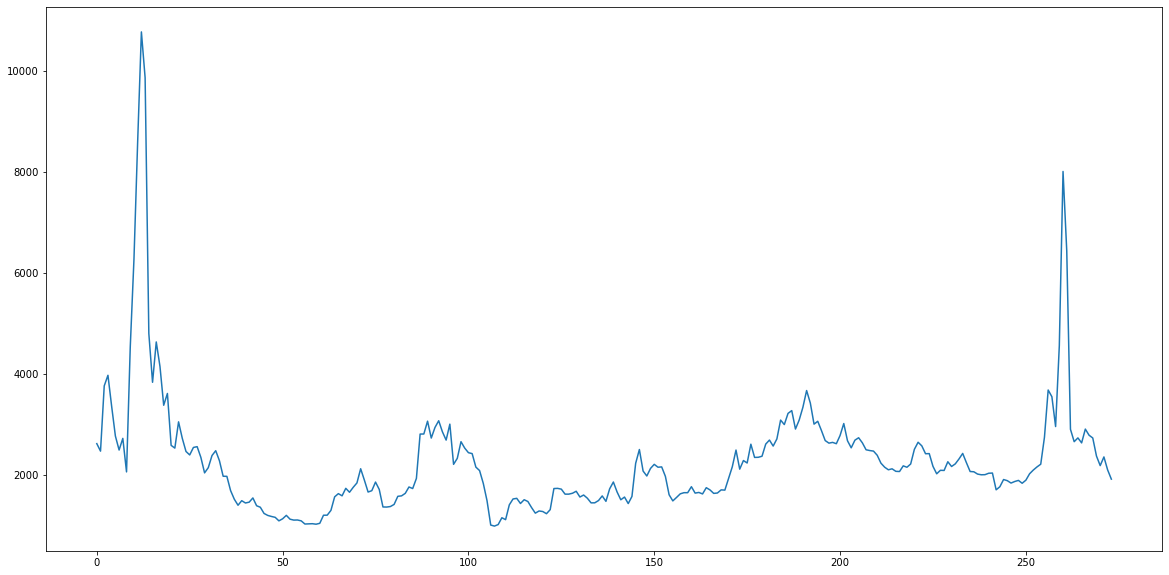

In [11]:
plt.figure(figsize=(20, 10))
plt.rcParams['font.family'] = 'NanumGothic'

samil.Close.plot()

In [13]:
kospi = fdr.DataReader('KS11', '2000')
kospi = kospi.reset_index()
kospi

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
kospi['Close'].plot()

In [ ]:
df = pd.merge(samil, kospi, on='Date', how='left')
df = df.drop(['Open_x','High_x','Low_x','Close_x','Close_y','Volume_x','Open_y','High_y','Low_y','Volume_y'], axis=1)
df.rename(columns={'Change_x':'Samil_Change', 'Change_y':'Kospi_Change'},inplace=True)
df

In [ ]:
df.info()

## 90일 기준으로 하락세 뽑아보기

In [ ]:
import numpy as np

In [ ]:
# a일수의 변동률 평균값

def RatioMean(a):
    result = []

    for i in range(len(df)):
        K = df.Kospi_Change[i:i+a].mean()
        D = df.Samil_Change[i:i+a].mean()
        
    # 하락 트리거만 잡기 위해 -1 외에 모두 1로 정의
        if len(df)-i < a:
            result.append(np.nan)
        elif (K < 0) & (D < 0):   # a일수간의 변동평균이 둘 다 - 일 때
            if K > D:
                result.append(-1)
            elif K < D:           # kospi 변동률보다 덜 변동
                result.append(1)
        elif (K > 0) & (D > 0):   # a일수간의 변동평균이 둘 다 + 일 때
            if K > D:
                result.append(-1)
            if K < D:             # 둘 다 + 이지만, kospi 변동률보다 적게 상승
                result.append(1)
        elif (K >= 0) & (D <= 0): # K 변동 평균은 양수지만 D 변동 평균이 음수일 때
            result.append(-1)
        elif (K <= 0) & (D >= 0): # K 변동 평균은 음수지만 D 변동 평균이 양수일 때
            result.append(1)

    return result

In [ ]:
Ratio_list = RatioMean(90)
print(Ratio_list[:10])
print('')
print(Ratio_list[-100:])

In [ ]:
len(Ratio_list)

In [ ]:
LowerThanKospi_3m = pd.DataFrame(Ratio_list,columns=['label'])
# LowerThanKospi_3m.Ratio_list = LowerThanKospi_3m['Ratio_list'] < 0
# LowerThanKospi_3m = LowerThanKospi_3m.fillna(0)

In [ ]:
LowerThanKospi_3m

In [ ]:
df

In [ ]:
LowerThanKospi_3m_label = pd.concat([df, LowerThanKospi_3m], axis=1)
LowerThanKospi_3m_label = LowerThanKospi_3m_label.fillna(1)

In [ ]:
LowerThanKospi_3m_label

In [ ]:
'''
# 하락 여부 label

label = []
for row in LowerThanKospi_3m.LowerThanKospi_3m:
    if row < 0:
        label.append(-1)
    elif row > 0:
        label.append(1)
    else:
        label.append(0)
    
LowerThanKospi_3m['label'] = label
LowerThanKospi_3m
'''

In [ ]:
LowerThanKospi_3m_label.label.isnull().sum()

In [ ]:
LowerThanKospi_3m_label.label.value_counts()

In [ ]:
LowerThanKospi_3m_label.label = LowerThanKospi_3m_label.label.replace(-1, 0)
LowerThanKospi_3m_label.label = LowerThanKospi_3m_label.label.replace(1, 0.2)
LowerThanKospi_3m_label

## 시각적으로 확인하기 위해 종가를 scaling 후 비교

In [ ]:
samil

In [ ]:
samil_scaled = samil.set_index('Date')
kospi_scaled = kospi.set_index('Date')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

fitted = scaler.fit(kospi_scaled)
kospi_scaled = scaler.transform(kospi_scaled)

fitted = scaler.fit(samil_scaled)
samil_scaled = scaler.transform(samil_scaled)

In [ ]:
samil_scaled = pd.DataFrame(samil_scaled, columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Change'])
kospi_scaled = pd.DataFrame(kospi_scaled, columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Change'])

In [ ]:
samil_scaled

In [ ]:
# 그래프에 날짜를 기준으로 표기하기 위해 index로 썼던 Date 추가

samil_scaled.insert(0, 'Date', samil['Date'])
kospi_scaled.insert(0, 'Date', kospi['Date'])

In [ ]:
a = 500
LowerThanKospi_3m_label_ = LowerThanKospi_3m_label[:a]
samil_scaled_ = samil_scaled[:a]
kospi_scaled_ = kospi_scaled[:a]

In [ ]:
samil_scaled_

In [ ]:
LowerThanKospi_3m_label

In [ ]:
# 주가 데이터 그래프

data1 = samil_scaled_
data2 = kospi_scaled_
data3 = LowerThanKospi_3m_label_

plt.figure(figsize=(20, 10))
plt.rcParams['font.family'] = 'NanumGothic'

# plt.subplot(2, 1, 1)
plt.axhline(y=0, color='black', linewidth=1)
sns.lineplot(data=data1, x="Date", y='Close', label='samil_price', color='brown')
sns.lineplot(data=data2, x="Date", y='Close', label='kospi_price', color='blue')
ax = sns.scatterplot(data=data3, x="Date", y="label", label='↓', color='black')

'''
plt.subplot(2, 1, 1)
plt.figure(figsize=(20, 10))
plt.axhline(y=0, color='r', linewidth=1)
sns.lineplot(data=data3, x="Date", y='Kospi_Change', label='kospi_change', color='orange')
sns.lineplot(data=data3, x='Date', y='CJ_Change', label='cj_change', color='skyBlue')
'''

plt.show()

In [ ]:
# 그래프 완곡하게
# 추세선 느낌

## 추출하기 위한 label 수정

In [ ]:
cj_scaled.Close

In [ ]:
close_merge = pd.merge(kospi_scaled, cj_scaled, on='Date')
# close_merge.columns = ['Kospi_Close', 'CJ_Close']
close_merge = close_merge.drop(['Open_x','High_x','Low_x','Volume_x','Open_y','High_y','Low_y','Volume_y','Change_x','Change_y'], axis=1)
close_merge.columns = ['Date','Kospi_Close', 'CJ_Close']
close_merge


In [ ]:
LowerThanKospi_3m_label.label = LowerThanKospi_3m_label.label.replace(0, 0)
LowerThanKospi_3m_label.label = LowerThanKospi_3m_label.label.replace(0.2, 1)
LowerThanKospi_3m_label.label = LowerThanKospi_3m_label.label.astype(int)
LowerThanKospi_3m_label

In [ ]:
final_cj = pd.merge(LowerThanKospi_3m_label, close_merge)
final_cj

In [ ]:
# 컬럼 위치 정리

final_cj = final_cj[['Date','Kospi_Close','Kospi_Change', 'CJ_Close', 'CJ_Change', 'label']]
final_cj

In [ ]:
pd.to_csv('final_cj.csv')

In [ ]:
kospi_scaled = pd.DataFrame(kospi_scaled, columns=kospi.columns, index=list(kospi.index.values)).reset_index()
kospi_scaled

In [ ]:
kospi_scaled.rename(columns={'index':'date'}, inplace=True)

In [ ]:
kospi_scaled

In [ ]:
kospi_scaled.Close.plot()

In [ ]:
cj_scaled = pd.DataFrame(cj_scaled, columns=cj.columns, index=list(cj.index.values)).reset_index()
cj_scaled

In [ ]:
cj_scaled.rename(columns={'index':'date'}, inplace=True)

In [ ]:
cj_scaled.Close.plot()

In [ ]:
cj_scaled[:10]

In [ ]:
cj_scaled[:10].Change.plot()

In [ ]:
# CJ에 없는 값 index 확인
'''
not_contain = pd.concat([kospi_scaled['date'], cj_scaled['date'], cj_scaled['date']]).drop_duplicates(keep=False)
not_contain

kospi_scaled['date'].str.contains('2003-09-23')

kospi_scaled = kospi_scaled.drop(index=[909, 1170, 1200, 3464], axis=0).reset_index()
kospi_scaled = kospi_scaled.drop(columns=['index'])
# kospi_scaled = kospi_scaled.drop(columns=['level_0'])
kospi_scaled
'''

In [ ]:
# 주가 데이터 그래프

plt.figure(figsize=(20, 10))
plt.rcParams['font.family'] = 'AppleGothic'
# plt.rcParams['font.size'] = 23
# plt.rcParams['figure.figsize'] = (13, 8) # figsize 고정
sns.lineplot(data=kospi_scaled, x="date", y="Close", label='kospi_scale', color='skyblue')
sns.lineplot(data=cj_scaled, x='date', y='Close', label='cj_scale', color='Blue')

plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.rcParams['font.family'] = 'AppleGothic'
cj_scaled.iloc[:10].Change.plot()
kospi_scaled.iloc[:10].Change.plot()

그러니까 scaling 후 두 값을 단순히 비교하는 것이 아닌 스케일링 값에서 3개월치의 변화량을 각자 구한후 변화량을 비교해야 맞을 듯
</br> 근데 생각해보니까 지수와 가격을 비교하는 것 이니까 각자 스케일링해서 비교해봐도 합당해 보이네..

### 일자별 변화율 구하기

In [ ]:
df = pd.merge(cj_scaled, kospi_scaled, on='date', how='left')
df = df.drop(['Open_x','High_x','Low_x','Close_x','Volume_x','Close_y','Open_y','High_y','Low_y','Volume_y'], axis=1)
df.rename(columns={'Change_x':'CJ_Change','Change_y':'Kospi_Change'},inplace=True)
df

In [ ]:
LowerThanKospi_1day = df[(df['Kospi_Change'] < 0) & (df['Kospi_Change'] > df['CJ_Change'])]
# LowerThanKospi_1day['LowerThanKospi_1day'] = -1
# LowerThanKospi_1day.drop(columns=['CJ_Close','Kospi_Close','CJ_Rate','Kospi_Rate'], axis=0, inplace=True)
LowerThanKospi_1day

In [ ]:
cj_rate = []
kospi_rate = []

for i in range(5622):
    cj_rate.append((df.CJ_Close[i+1]-df.CJ_Close[i])/df.CJ_Close[i] * 100)
    kospi_rate.append((df.Kospi_Close[i+1]-df.Kospi_Close[i])/df.Kospi_Close[i] * 100)
    

In [ ]:
cj_rate.insert(0, 0)
cj_rate

In [ ]:
kospi_rate.insert(0, 0)
kospi_rate

In [ ]:
len(cj_rate)

In [ ]:
df_ratio = pd.DataFrame({'date':df['date'],
                         'CJ_Rate':cj_rate,
                         'Kospi_Rate':kospi_rate,
                        })
df_ratio

In [ ]:
df = pd.merge(df, df_ratio, on='date', how='left')
# kospi_loww = kospi_loww.fillna(0)
# kospi_loww.day_low = kospi_loww.day_low.replace(-1, -10)
df

In [ ]:
LowerThanKospi_1day = df[(df['Kospi_Rate'] < 0) & (df['Kospi_Rate'] > df['CJ_Rate'])]
LowerThanKospi_1day['LowerThanKospi_1day'] = -1
LowerThanKospi_1day.drop(columns=['CJ_Close','Kospi_Close','CJ_Rate','Kospi_Rate'], axis=0, inplace=True)
LowerThanKospi_1day

In [ ]:
LowerThanKospi_1day = pd.merge(df, LowerThanKospi_1day, on='date', how='outer')
LowerThanKospi_1day = LowerThanKospi_1day.fillna(0)

In [ ]:
LowerThanKospi_1day['LowerThanKospi_1day'] =  LowerThanKospi_1day['LowerThanKospi_1day'].replace(-0.5, -0.1)
LowerThanKospi_1day

In [ ]:
LowerThanKospi_1day.info()

In [ ]:
1007/5623 *100

In [ ]:
LowerThanKospi_1day = LowerThanKospi_1day[:100]

In [ ]:
LowerThanKospi_1day

In [ ]:
# cj 대한통운 가격과 kospi 지수 변동율 그래프

plt.figure(figsize=(20, 10))
# plt.ylim([-0.5, 0.5]) 
plt.rcParams['font.family'] = 'AppleGothic'
ax = sns.lineplot(data=LowerThanKospi_1day, x="date", y="Kospi_Close", label='Kospi_Close', color='blue')
ax = sns.lineplot(data=LowerThanKospi_1day, x="date", y="CJ_Close", label='CJ_Close', color='orange')
ax = sns.lineplot(data=LowerThanKospi_1day, x="date", y="LowerThanKospi_1day", label='↓', color='black')
# ax = sns.scatterplot(data=LowerThanKospi_1day, x="date", y="LowerThanKospi_1day", label='↓', color='black')

ax.set_xlabel('Date')
ax.set_ylabel('Rate')

plt.show()